In [31]:
# Define Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, accuracy_score

import warnings
warnings.filterwarnings('ignore')


In [89]:
#load file
df=pd.read_csv("food_coded.csv")
df.head(5)

#print(X.columns)
#print(y.columns)
#print(y.head(5))


# Simplying data due to low training data avaialble
    # Removing 2,6,7 categroy due to low count
    # Adding 8 to 4 because indian food also comes under the umbrella of Asian food
    # Removing 0 because they are undecided and have low counts

print(df.groupby(['fav_cuisine_coded']).fav_cuisine_coded.count())

df.loc[df['fav_cuisine_coded']==8] = 4
df=df[df['fav_cuisine_coded'].isin([1,2,4,5])]

print(df.groupby(['fav_cuisine_coded']).fav_cuisine_coded.count())
print((df.groupby(['fav_cuisine_coded']).fav_cuisine_coded.count())/len(df))
# Split it into input features and output 

average_rate = ((df.groupby(['fav_cuisine_coded']).fav_cuisine_coded.count())/len(df))


fav_cuisine_coded
0     6
1    59
2    15
3     2
4    22
5    15
6     1
7     1
8     4
Name: fav_cuisine_coded, dtype: int64
fav_cuisine_coded
1    59
2    15
4    26
5    15
Name: fav_cuisine_coded, dtype: int64
fav_cuisine_coded
1    0.513043
2    0.130435
4    0.226087
5    0.130435
Name: fav_cuisine_coded, dtype: float64


In [33]:

#for (i,names) in enumerate(df.columns):
    #print (i," : ",names)
string_cols = [0,7,8,13,16,24,25,28,34,35,42,44,56,60]    
#0 cleanign string 

df_retain = df.drop(df.columns[string_cols], axis = 1) 
#print(df_retain.head(5))



In [34]:
#data cleaning

    # Taqi code will come here, i am just getting the column as it is 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer.fit(df_retain)
X = imputer.transform(df_retain)
df_sel_clean = pd.DataFrame(X,columns = df_retain.columns)


In [35]:
#test-train split using stratification

# STRATIFIED SAMPLING 
X = df_sel_clean.loc[:, df_sel_clean.columns != 'fav_cuisine_coded']
y = df_sel_clean[['fav_cuisine_coded']]

X_train, tempX_test, y_train, tempY_test = train_test_split(X, y,stratify=y,test_size=0.30)
x_val, x_test, y_val, y_test = train_test_split(tempX_test, tempY_test,stratify=tempY_test,test_size=0.64)

# Training Set : X_train, y_train
# Validation Set : x_val ,  y_val
# Testing Set : x_test , y_test


#print(y_train.groupby(['fav_cuisine_coded']).fav_cuisine_coded.count())
#print(y_test.groupby(['fav_cuisine_coded']).fav_cuisine_coded.count())
#print(y_val.groupby(['fav_cuisine_coded']).fav_cuisine_coded.count())
#print(X_train.head(2))

In [36]:
def feature_selection_RF(X_train, y_train,x_val ,  y_val):
    clf = RandomForestClassifier(n_estimators = 100, random_state=0, n_jobs=-1)
    clf.fit(X_train, y_train)
    #for feature in zip(X_train.columns, clf.feature_importances_):
        #print(feature)
    sfm = SelectFromModel(clf, threshold=0.02)
    sfm.fit(X_train, y_train)
    #for feature_list_index in sfm.get_support(indices=True):
        #print(X_train.columns[feature_list_index])
    
    X_important_train = sfm.transform(X_train)
    X_important_val = sfm.transform(x_val)
    
    clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf_important.fit(X_important_train, y_train)
    
    y_pred = clf.predict(x_val)
    acc_full = accuracy_score(y_val, y_pred)
    print(acc_full)
    
    y_important_pred = clf_important.predict(X_important_val)
    acc_new = accuracy_score(y_val, y_important_pred)
    print(acc_new)
    top__cols = list(X_train.columns[sfm.get_support(indices=True)])
    #print(top__cols)
    return top__cols

In [37]:
#standardization

    # This will be done once data is cleaned

In [38]:
# Data Exploration
    # scatter plots
    # histograms
    # Box plot 
    # Line chart etc

# Just put whatever you think is related to our model. 


In [39]:
def correlation_matrix(df_1):
    from matplotlib.colors import ListedColormap
    
    corrMatrix = df.corr()
    fig, ax = plt.subplots(figsize=(30,30))
    #sns.heatmap(corrMatrix,cmap=ListedColormap(['green','green', 'yellow','red', 'red']), annot=True,linewidths=.5, ax=ax)
    sns.heatmap(corrMatrix, annot=True,linewidths=.5, ax=ax)   
    plt.show()

In [40]:
#correlation_matrix(df_sel_clean)

In [41]:
def chi_square_feature_sel(X_train,y_train,total_col_selected):
    df_train_chi_ind = X_train
    df_train_chi_dep = y_train
    
    bestfeatures = SelectKBest(score_func=chi2, k=20)
    fit = bestfeatures.fit(df_train_chi_ind,df_train_chi_dep)
    
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_train_chi_ind.columns)
    
    #concat two dataframes for better visualization 
    
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(20,'Score'))  #print 10 best features
    
    top_n_columns = featureScores.sort_values('Score',ascending=False).head(total_col_selected).Specs
    return top_n_columns

In [42]:
top_n_cols = chi_square_feature_sel(X_train,y_train,20)
top_n_cols_RF = feature_selection_RF(X_train, y_train,x_val,y_val)

top_n_cols_final =  set(top_n_cols).intersection(set(top_n_cols_RF))
#top_n_cols.append('fav_cuisine_coded')
print( set(top_n_cols) & set(top_n_cols_RF))

#Commenting others and proceeding with the data that gives best ensemble learning accuracy on test set

# X_train =  X_train[X_train.columns.intersection(top_n_cols_final)]
# x_val =  x_val[x_val.columns.intersection(top_n_cols_final)]
# x_test =  x_test[x_test.columns.intersection(top_n_cols_final)]

top_n_cols=list(top_n_cols)
X_train =  X_train[X_train.columns.intersection(top_n_cols)]
x_val =  x_val[x_val.columns.intersection(top_n_cols)]
x_test =  x_test[x_test.columns.intersection(top_n_cols)]

# X_train =  X_train[X_train.columns.intersection(top_n_cols_RF)]
# x_val =  x_val[x_val.columns.intersection(top_n_cols_RF)]
# x_test =  x_test[x_test.columns.intersection(top_n_cols_RF)]

#df_sel_features =  df_sel_clean[df_sel_clean.columns.intersection(top_n_cols)]

0.5833333333333334
0.4166666666666667
{'ethnic_food', 'healthy_feeling', 'persian_food', 'income', 'turkey_calories', 'indian_food', 'mother_education', 'exercise', 'tortilla_calories', 'waffle_calories', 'calories_chicken', 'thai_food', 'life_rewarding', 'comfort_food_reasons_coded', 'ideal_diet_coded', 'calories_scone', 'cuisine'}


In [43]:
#model implementation
from sklearn.linear_model import LogisticRegression
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X_train, y_train)

c_est = softmax_reg.predict(x_val)
probs = softmax_reg.predict_proba(x_val)
print(c_est)

#print(x_val)
#print(y_val)

from sklearn.metrics import accuracy_score

#accuracy_score(y_val, c_est)


# GBT (Gradient Boosting Trees)
# Logistic Regeression

#Ensemble Learning 


c_est = softmax_reg.predict(x_test)
accuracy_score(y_test, c_est)



[1. 1. 1. 1. 4. 2. 1. 1. 1. 2. 1. 1.]


0.4782608695652174

In [44]:
#Grid search for finding right hyperparameter for Multinomial and One vs All Regression

from sklearn.model_selection import GridSearchCV

acc_scorer = make_scorer(accuracy_score)

grid={"C":np.logspace(-3,3,7),"multi_class":["multinomial","ovr",], "penalty":["l1","l2"], "solver":["lbfgs","saga","newton-cg"]} # l1 lasso l2 ridge
logreg=LogisticRegression(random_state=42)
logreg_cv=GridSearchCV(logreg, grid, cv=10, scoring=acc_scorer)
logreg_cv.fit(X_train,y_train)


print("Tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("Accuracy :",logreg_cv.best_score_)


# Set the logreg_best to the best combination of parameters
logreg_best = logreg_cv.best_estimator_

# Fit the best algorithm to the data. 
logreg_best.fit(X_train, y_train)

logreg_est = logreg_best.predict(x_test)
accuracy_score(y_test, logreg_est)

print (logreg_est)

Tuned hpyerparameters :(best parameters)  {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.5875
[1. 1. 2. 2. 1. 1. 1. 4. 1. 4. 2. 4. 4. 1. 1. 4. 5. 4. 4. 1. 1. 1. 2.]


In [45]:
#Grid search for finding right hyperparameter for Gradient Boost Classification

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# parameters = {
#     "loss":["deviance"],
#     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#     "max_depth":[3,5,8],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#     "n_estimators":[10]
#     }

#Using a subset of parameters for early computation, more parameters could be added from above sample

parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "n_estimators":[10, 20, 30, 40 ,50, 60, 70, 80, 90, 100]
    }

acc_scorer = make_scorer(accuracy_score)

grad_cv = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters, cv=10, scoring=acc_scorer)
grad_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",grad_cv.best_params_)
print("accuracy :",grad_cv.best_score_)

# Set the grad_best to the best combination of parameters
grad_best = grad_cv.best_estimator_

# Fit the best algorithm to the data. 
grad_best.fit(X_train, y_train)

grad_est = grad_best.predict(x_test)
accuracy_score(y_test, grad_est)

print (grad_est)

tuned hpyerparameters :(best parameters)  {'learning_rate': 0.075, 'n_estimators': 40}
accuracy : 0.525
[1. 2. 2. 4. 1. 5. 2. 4. 1. 1. 1. 1. 4. 1. 1. 1. 1. 4. 1. 1. 4. 1. 2.]


In [46]:
#Grid search for finding right hyperparameter for Ada Boost Classification

from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "n_estimators":[10, 20, 30, 40 ,50, 60, 70, 80, 90, 100]
    }

acc_scorer = make_scorer(accuracy_score)

ada_cv = GridSearchCV(AdaBoostClassifier(random_state=42), parameters, cv=10, scoring=acc_scorer)
ada_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",ada_cv.best_params_)
print("accuracy :",ada_cv.best_score_)

# Set the ada_best to the best combination of parameters
ada_best = ada_cv.best_estimator_

# Fit the best algorithm to the data. 
ada_best.fit(X_train, y_train)

ada_est = ada_best.predict(x_test)
accuracy_score(y_test, ada_est)

print (ada_est)

tuned hpyerparameters :(best parameters)  {'learning_rate': 0.05, 'n_estimators': 90}
accuracy : 0.525
[1. 1. 2. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1.]


In [47]:
#Ensemble learning implementation, with Logistic Regression (Multinomial or OVA), Gradient and Ada-Boost 

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss

voting_clf = VotingClassifier(estimators=[('LRM', logreg_best), ('GDB', grad_best), ('ADB', ada_best)], voting='soft')
voting_clf.fit(X_train, y_train)

preds = voting_clf.predict(x_test)
acc = accuracy_score(y_test, preds)

print("Accuracy is: " + str(acc))
print (preds)

Accuracy is: 0.5652173913043478
[1. 1. 2. 4. 1. 1. 2. 4. 1. 1. 5. 1. 4. 1. 1. 4. 1. 4. 4. 1. 1. 1. 2.]


In [48]:
#test-train split using StratifiedKFold that also shuffles the data

from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit

X = df_sel_clean.loc[:, df_sel_clean.columns != 'fav_cuisine_coded']
y = df_sel_clean[['fav_cuisine_coded']]

cv = StratifiedKFold(n_splits=5)
for train, test in cv.split(X,y):
    print(train)

[ 19  20  24  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  21  22  23  25  43  44  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  45  46  47  66  67  69  72  73  74  75  76
  77  78  79  80  81  82  83  8

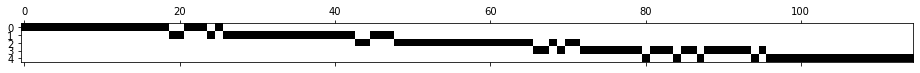

In [49]:
#Function for visualization of K-fold Stratified Sampling with 5 splits

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.matshow(masks, cmap='gray_r')
    
plot_cv(StratifiedKFold(n_splits=5),X,y)

In [50]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(voting_clf, X, y, cv=cv)
print(scores)
print("Mean:", np.mean(scores.mean()))
print("Standard deviation:", np.mean(scores.std()))

#Small SD indicates that the model doesn't overfit to a particular chunk of a data

[0.47826087 0.60869565 0.43478261 0.47826087 0.52173913]
Mean: 0.5043478260869565
Standard deviation: 0.058976782461958865


In [51]:
from sklearn.metrics import multilabel_confusion_matrix

# classes = ['Italian/French/Greek', 'Spanish/mexican', 'Asian/Chinese/Thai/Nepal/Indian', 'American']
# multilabel_confusion_matrix(y_test, preds)

In [60]:
from sklearn.metrics import confusion_matrix

classes = ['Italian/French/Greek', 'Spanish/mexican', 'Asian/Chinese/Thai/Nepal/Indian', 'American']
#confusion_matrix(y_test, preds)

                                 precision    recall  f1-score   support

           Italian/French/Greek       0.69      0.75      0.72        12
                Spanish/mexican       0.33      0.33      0.33         3
Asian/Chinese/Thai/Nepal/Indian       0.50      0.60      0.55         5
                       American       0.00      0.00      0.00         3

                       accuracy                           0.57        23
                      macro avg       0.38      0.42      0.40        23
                   weighted avg       0.51      0.57      0.54        23



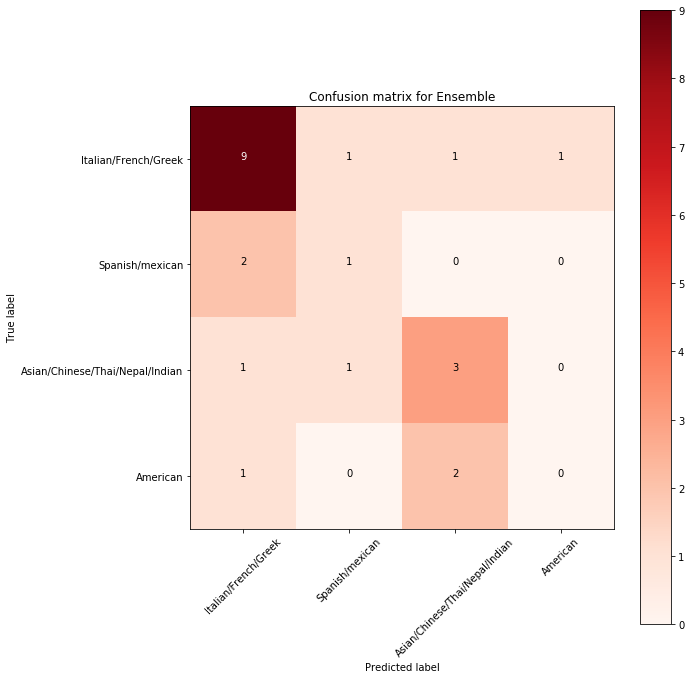

In [93]:
# print or plot  metrics / results

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

classes = ['Italian/French/Greek', 'Spanish/mexican', 'Asian/Chinese/Thai/Nepal/Indian', 'American']
print(classification_report(y_test, preds, target_names=classes))

cm = confusion_matrix(y_test, preds)
classes = ['Italian/French/Greek', 'Spanish/mexican', 'Asian/Chinese/Thai/Nepal/Indian', 'American']
fig = plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion matrix for Ensemble')
plt.colorbar()
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

normalize = False
fmt = '.2f' if normalize else 'd'

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [88]:
#Calculating lifts for the selected model

#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#The diagonal entries are the accuracies of each class
predicted_values = cm.diagonal()

print("Lift for Italian/French/Greek:", predicted_values[0]/average_rate[1])
print("Lift for Spanish/mexican:", predicted_values[1]/average_rate[2])
print("Lift for Asian/Chinese/Thai/Nepal/Indian:", predicted_values[2]/average_rate[4])
print("Lift for American:", predicted_values[3]/average_rate[5])

Lift for Italian/French/Greek: 1.461864406779661
Lift for Spanish/mexican: 2.5555555555555554
Lift for Asian/Chinese/Thai/Nepal/Indian: 2.6538461538461537
Lift for American: 0.0


In [58]:
# Final hold-out sample testing